In [ ]:
import * from utils

rat_name = 'R'
mod_name = '1'
sess_name = 'OF'
day_name = 'day1'

dim = 6
ph_classes = [0,1] # Decode the ith most persistent cohomology class
num_circ = len(ph_classes)
dec_tresh = 0.99
metric = 'cosine'
maxdim = 1
coeff = 47
active_times = 15000
k = 1000
num_times = 5
n_points = 1200
nbs = 800

sspikes = get_spikes(rat_name, mod_name, day_name, sess_name, bType = 'pure',
                                 bSmooth = True, bSpeed = True)[0]


In [ ]:
num_neurons = len(sspikes[0,:])            
times_cube = np.arange(0,len(sspikes[:,0]),num_times)
movetimes = np.sort(np.argsort(np.sum(sspikes[times_cube,:],1))[-active_times:])
movetimes = times_cube[movetimes]

ssspikes = preprocessing.scale(sspikes[movetimes,:],axis = 0)

dgms = {}
for i in np.arange(3,41):
    dim_red_spikes_move_scaled,__,__  = pca(ssspikes, dim = i)
    indstemp,dd,fs  = sample_denoising(dim_red_spikes_move_scaled,  k, 
                                        n_points, 1, metric)

    X = squareform(pdist(dim_red_spikes_move_scaled[indstemp,:], metric))
    knn_indices = np.argsort(X)[:, :nbs]
    knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()
    sigmas, rhos = smooth_knn_dist(knn_dists, nbs, local_connectivity=0)
    rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
    result = coo_matrix((vals, (rows, cols)), shape=(X.shape[0], X.shape[0]))
    result.eliminate_zeros()
    transpose = result.transpose()
    prod_matrix = result.multiply(transpose)
    result = (result + transpose - prod_matrix)
    result.eliminate_zeros()
    d = result.toarray()
    d = -np.log(d)
    np.fill_diagonal(d,0)
    thresh = np.max(d[~np.isinf(d)])
    rips_real = ripser(d, maxdim=maxdim, coeff=coeff, thresh = thresh, 
                       do_cocycles=False, distance_matrix = True)
    dgms[i] = rips_real["dgms"]
    print(i)
    
np.savez('pca_analysis_R1', dgms_all = dgms)


[Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')]

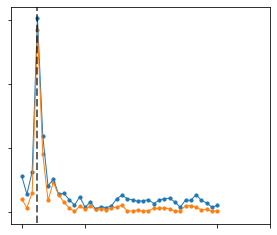

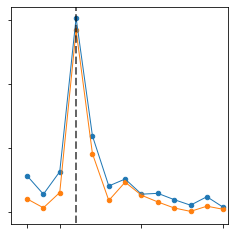

In [8]:


f = np.load('pca_analysis_R1.npz', allow_pickle = True)

dgms = f['dgms_all'][()]
f.close()

dims = np.arange(3,41)
lives_top3_mod1 = np.zeros((len(dims),3))

lives_std_mod1 = np.zeros((len(dims),1))

lives_med_mod1 = np.zeros((len(dims),1))

lives_mean_mod1 = np.zeros((len(dims),1))

lives_gap_mod1 = np.zeros((len(dims),1))

lives_gapmax_mod1 = np.zeros((len(dims),1))

lives_gap1_mod1 = np.zeros((len(dims),1))
lives_gap2_mod1 = np.zeros((len(dims),1))
lives_gap3_mod1 = np.zeros((len(dims),1))

for it, dim in enumerate(dims):
    diagrams = dgms[dim].copy()
    births1 = diagrams[1][:, 0] 
    deaths1 = diagrams[1][:, 1] 
    lives1 = deaths1-births1 
    iMax = np.argsort(lives1)
    lives_top3_mod1[it,:] = lives1[iMax[-3:]] 
    lives_std_mod1[it,:] = np.std(lives1)
    lives_med_mod1[it,:] = np.median(lives1)
    lives_mean_mod1[it,:] = np.mean(lives1)
    gaps = lives1[iMax[1:]] - lives1[iMax[:-1]]
    lives_gap_mod1[it] = len(gaps)-np.argmax(gaps)
    lives_gapmax_mod1[it] = np.max(gaps)
    lives_gap1_mod1[it] = gaps[-1]
    lives_gap2_mod1[it] = gaps[-2]
    lives_gap3_mod1[it] = gaps[-3]

    

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(dims, np.divide(lives_top3_mod1[:,2],lives_top3_mod1[:,0]), lw = 1)
ax.plot(dims, np.divide(lives_top3_mod1[:,1],lives_top3_mod1[:,0]), lw = 1)
ax.scatter(dims, np.divide(lives_top3_mod1[:,2],lives_top3_mod1[:,0]), s = 10, lw = 1)
ax.scatter(dims, np.divide(lives_top3_mod1[:,1],lives_top3_mod1[:,0]), s = 10, lw = 1)
ax.plot([6,6], [ax.get_ylim()[0],ax.get_ylim()[1]], ls = '--',c = 'k', alpha = 0.6, lw = 2)
ax.set_ylim([0.8, 4.2])
ax.set_aspect(1.0/ax.get_data_ratio())
ax.set_xticks([3,15, 50, dims[-1]])
ax.set_xticklabels(['','','',''])
ax.set_yticks([ 1, 2, 3,4, ])
ax.set_yticklabels(['','','',''])


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(dims[:13], np.divide(lives_top3_mod1[:13,2],lives_top3_mod1[:13,0]), lw = 1)
ax.plot(dims[:13], np.divide(lives_top3_mod1[:13,1],lives_top3_mod1[:13,0]), lw = 1)
#ax.plot(dims[:13], np.divide(lives_top3_mod1[:13,0],lives_top3_mod1[:13,0]), lw = 1)
ax.scatter(dims[:13], np.divide(lives_top3_mod1[:13,2],lives_top3_mod1[:13,0]), s = 20, lw = 1)
ax.scatter(dims[:13], np.divide(lives_top3_mod1[:13,1],lives_top3_mod1[:13,0]), s = 20, lw = 1)
#ax.scatter(dims[:13], np.divide(lives_top3_mod1[:13,0],lives_top3_mod1[:13,0]), s = 20, lw = 1)
ax.plot([6,6], [ax.get_ylim()[0],ax.get_ylim()[1]], ls = '--',c = 'k', alpha = 0.6, lw = 2)
#ax.plot([ax.get_xlim()[0],ax.get_xlim()[1]], [1,1],  ls = '--',c = 'k', alpha = 0.6, lw = 1)
ax.set_ylim([0.8, 4.2])
ax.set_xlim([2, 15.3])
ax.set_aspect(1.0/ax.get_data_ratio())
ax.set_xticks([3, 5,10,15])
#ax.set_xticks([3, 6,11,16])
ax.set_xticklabels(['','','',''])
ax.set_yticks([1, 2,3, 4])
ax.set_yticklabels(['','','',''])



In [ ]:
########### Plot pca space ###################
sig = 2.75
ph_classes = [0,1] # Decode the ith most persistent cohomology class
num_circ = len(ph_classes)
dec_tresh = 0.99
metric = 'cosine'
maxdim = 1
coeff = 47
active_times = 15000
k = 1000
num_times = 5
n_points = 1200
nbs = 800
eval_all = {}
dev_OF = {}
numangsint = 51
numangsint_1 = numangsint-1
bins = np.linspace(0,1, numangsint)
dim = 15
num_bins = 15
GoGaussian = True
nF2 = 2

for rat_name, mod_name, sess_name, day_name in (('R', '1', 'OF', 'day1'),
                                                ('R', '2', 'OF', 'day1'),
                                                ('R', '3', 'OF', 'day1'),
                                                ('R', '1', 'WW', 'day1'),
                                                ('R', '2', 'WW', 'day1'),
                                                ('R', '3', 'WW', 'day1'),
                                                ('R', '1', 'OF', 'day2'),
                                                ('R', '2', 'OF', 'day2'),
                                                ('R', '3', 'OF', 'day2'),
                                                ('R', '1', 'REM', 'day2'),
                                                ('R', '2', 'REM', 'day2'),
                                                ('R', '3', 'REM', 'day2'),
                                                ('R', '1', 'SWS', 'day2'),
                                                ('R', '2', 'SWS', 'day2'),
                                                ('R', '3', 'SWS', 'day2'),
                                                ('Q', '1', 'OF', ''),
                                                ('Q', '2', 'OF', ''),
                                                ('Q', '1', 'WW', ''),
                                                ('Q', '2', 'WW', ''),
                                                ('Q', '1', 'REM', ''),
                                                ('Q', '2', 'REM', ''),
                                                ('Q', '1', 'SWS', ''),
                                                ('Q', '2', 'SWS', ''),
                                                ('S', '1', 'OF', ''),
                                                ('S', '1', 'WW', ''),
                                                ('S', '1', 'REM', ''),
                                                ('S', '1', 'SWS', '')
                                                ):
    if sess_name in ('OF','WW'):
        sspikes,xx,yy = get_spikes(rat_name, mod_name, day_name, sess_name, bType = 'pure',
                                         bSmooth = True, bSpeed = True)[:3]
    else:
        sspikes = get_spikes(rat_name, mod_name, day_name, sess_name, bType = 'pure',
                                             bSmooth = True, bSpeed = False)


    num_neurons = len(sspikes[0,:])            
    times_cube = np.arange(0,len(sspikes[:,0]),num_times)
    movetimes = np.sort(np.argsort(np.sum(sspikes[times_cube,:],1))[-active_times:])
    movetimes = times_cube[movetimes]
    dim_red_spikes_move_scaled, evals, __  = pca(preprocessing.scale(sspikes[movetimes,:],axis = 0), dim = dim)
    
    eval_all[rat_name+mod_name+sess_name+day_name] = evals
    if sess_name in ('OF'):
        xx = normit(xx)
        yy = normit(yy)
        xx = xx[movetimes]
        yy = yy[movetimes]
        torscores = np.zeros((dim, 4))        

        for n in range(dim):
            mtottemp, x_edge, y_edge,c2 = binned_statistic_2d(xx, yy, 
                                                  dim_red_spikes_move_scaled[:,n], statistic='mean', 
                                                  bins=bins, range=None, expand_binnumbers=True)
            mtottemp = smooth_tuning_map(np.rot90(mtottemp), len(mtottemp)+1, sig, bClose = True)   
            plt.figure()
            plt.imshow(mtottemp, origin = 'lower', vmin = -2.5, vmax = 2.5)
            for l, LAM in enumerate((np.sqrt(1),)):
                torscores[n, l] = glm2d(np.concatenate((xx[:,np.newaxis],yy[:,np.newaxis]),1), 
                                        dim_red_spikes_move_scaled[:,n], 
                                        num_bins, True, LAM, GoGaussian, nF2)

        dev_OF[rat_name+mod_name+sess_name+day_name] = torscores[:, np.argmax(np.mean(torscores,0))]



105907.61790253884 0.04785634456369903 -0.031146324232525075
105132.04555302764 0.09499993065410997 -0.06206866278068257
45889.98640323053 3.2375371871937113 -4.373956279577299
45889.98541765248 3.2375161600035964 -4.373952957714195
105907.61790253884 0.04785634456369903 -0.031146324232525075
105132.04555302764 0.09499993065410997 -0.06206866278068257
45889.98640323053 3.2375371871937113 -4.373956279577299
45889.98541765248 3.2375161600035964 -4.373952957714195
53002.73300335348 -0.1602714154711804 -0.1602714154711804
52713.755078910704 -0.1923256985654165 -0.1923256985654165
52701.714332058924 -0.20033926933897545 -0.20033926933897545
52701.714332058924 -0.20033926933897545 -0.20033926933897545
52904.884899185374 0.16027141547117885 0.16027141547117885
52615.9069747426 0.19232569856541457 0.19232569856541457
52603.866227890816 0.20033926933897353 0.20033926933897353
52603.866227890816 0.20033926933897353 0.20033926933897353
94543.87211318992 0.033450015558746056 -0.036600524724351075


23391.009784391354 0.009103559950538942 -0.0199958688292444
23290.753385885542 0.018118381859316475 -0.03972688386295892
15391.60429241846 1.6968122772298637 -1.8231989082324933
15391.603947934987 1.696815061866864 -1.8232032163729124
23391.009784391354 0.009103559950538942 -0.0199958688292444
23290.753385885542 0.018118381859316475 -0.03972688386295892
15391.60429241846 1.6968122772298637 -1.8231989082324933
15391.603947934987 1.696815061866864 -1.8232032163729124
12244.437985236349 0.013856891367955688 0.013856891367955688
12242.277834054536 0.016628269641546827 0.016628269641546827
12242.191428007263 0.017182545296265058 0.017182545296265058
12242.187971765372 0.0172934004272087 0.0172934004272087
11146.571799155005 -0.01385689136795679 -0.01385689136795679
11144.411647973193 -0.01662826964154815 -0.01662826964154815
11144.325241925919 -0.017182545296266418 -0.017182545296266418
11144.321785684027 -0.017293400427210073 -0.017293400427210073
22808.706844931505 0.005611079078960149 -0

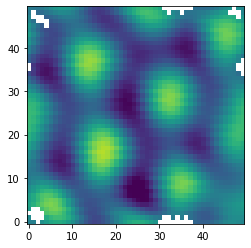

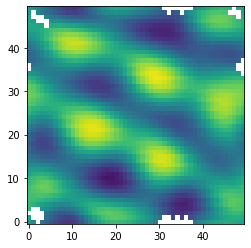

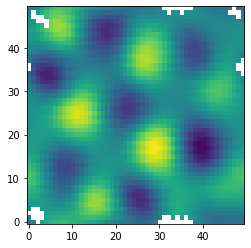

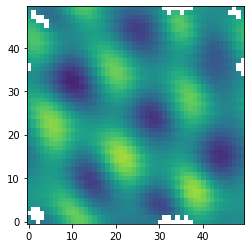

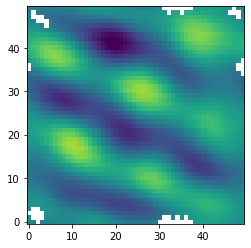

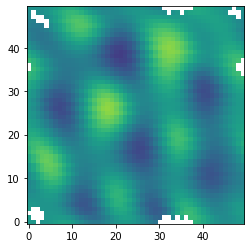

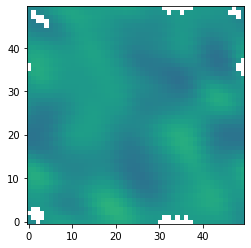

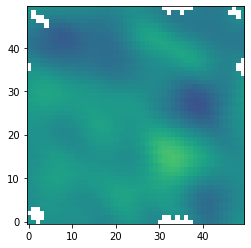

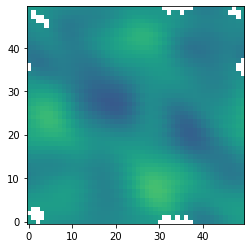

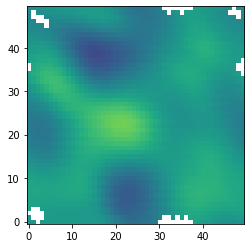

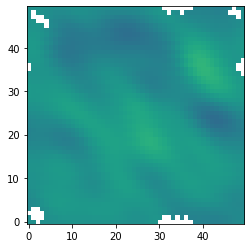

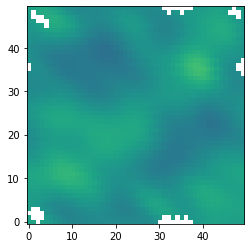

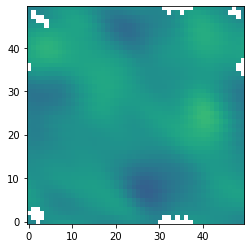

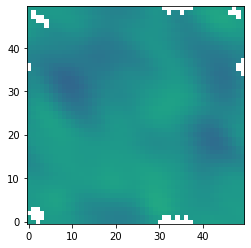

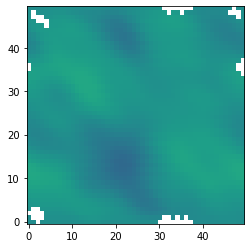

In [43]:

torscores = np.zeros((dim, 4))        

for n in range(dim):
    mtottemp, x_edge, y_edge,c2 = binned_statistic_2d(xx, yy, 
                                          dim_red_spikes_move_scaled[:,n], statistic='mean', 
                                          bins=bins, range=None, expand_binnumbers=True)
    mtottemp = smooth_tuning_map(np.rot90(mtottemp), len(mtottemp)+1, sig, bClose = True)   
    plt.figure()
    plt.imshow(mtottemp, origin = 'lower', vmin = -2.5, vmax = 2.5)
    for l, LAM in enumerate((np.sqrt(1),)):
        torscores[n, l] = glm2d(np.concatenate((xx[:,np.newaxis],yy[:,np.newaxis]),1), 
                                dim_red_spikes_move_scaled[:,n], 
                                num_bins, True, LAM, GoGaussian, nF2)

dev_OF[rat_name+mod_name+sess_name+day_name] = torscores[:, np.argmax(np.mean(torscores,0))]



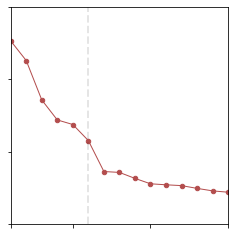

In [29]:

fig = plt.figure()
ax = fig.add_subplot(111)

for k in eval_all:                                                
    ax.plot(np.arange(1, 16), eval_all[k], 
            lw = 1, c = colors_mods[k[:2]][0])
    ax.scatter(np.arange(1, 16), eval_all[k], s = 20, lw = 1, 
               c = colors_envs[k])
    ax.set_xticks([1,5,10,15])
    ax.set_xticklabels(['','','',''])
    ax.set_yticks([0,3,6,9])
    ax.set_yticklabels(['','','',''])
    ax.set_xlim([1, 15])
    ax.set_ylim([0, 9])
    ax.plot([6,6], [0,ax.get_ylim()[1]], ls = '--', alpha = 0.1, lw = 2, c = 'k')
    ax.set_aspect(1.0/ax.get_data_ratio())


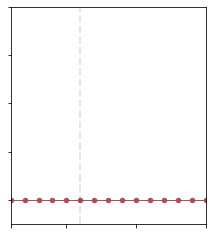

In [44]:

fig = plt.figure()
ax = fig.add_subplot(111)

for k in dev_OF:                                                
    ax.plot(np.arange(1, 16), dev_OF[k], 
            lw = 1, c = colors_mods[k[:2]][0])
    ax.scatter(np.arange(1, 16), dev_OF[k], s = 20, lw = 1, 
               c = colors_envs[k])
    ax.set_ylim([-0.1, 0.8])
    ax.plot([6,6], [ax.get_ylim()[0],ax.get_ylim()[1]], ls = '--', alpha = 0.1, lw = 2, c = 'k')
    ax.set_aspect(1.0/ax.get_data_ratio())
    ax.set_xticks([1,5,10,15])
    ax.set_xticklabels(['','','',''])
    ax.set_yticks([0,0.2,0.4, 0.6,0.8])
    ax.set_yticklabels(['','','','',''])
    ax.set_xlim([1, 15])
